In [1]:
import numpy as np
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras import layers
from keras.utils import load_img, img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
init = RandomNormal(stddev= 0.02, seed= 1337)
opt = Adam(0.0002, 0.5)

In [3]:
def encoder(layer_in, n_filters, batch_norm= True):
    g = layers.Conv2D(n_filters, 4, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    res = layers.Conv2D(n_filters, 1, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    g = layers.add([g, res])
    g = layers.LeakyReLU(alpha= 0.2)(g)  
    
    return g

In [4]:
def decoder(layer_in, skip_in, n_filters):
    g = layers.Conv2DTranspose(n_filters, 4, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    g = layers.Concatenate()([g, skip_in])
    g = layers.LeakyReLU(alpha= 0.2)(g)
    
    return g

In [5]:
def build_generator(latent_shape, img_shape= (256, 256, 3)):
    in_img = layers.Input(latent_dim)
    
    x = layers.Dense(256*256*3,input_dim= latent_shape)(in_img)
    x = layers.LeakyReLU(alpha= 0.2)(x)
    x = layers.Reshape((256,256,3))(x)

    e1 = encoder(x, 64)
    e2 = encoder(e1, 128)
    e3 = encoder(e2, 256)
    e4 = encoder(e3, 512)
    
    b = layers.Conv2D(1024, 4, strides= 2, padding='same', kernel_initializer=init)(e4)
    b = layers.LeakyReLU(alpha= 0.2)(b)
    
    d1 = decoder(b, e4, 512)
    d2 = decoder(d1, e3, 256)
    d3 = decoder(d2, e2, 128)
    d4 = decoder(d3, e1, 64)
    
    out_img = layers.Conv2DTranspose(3, 4, strides= 2, padding= 'same', kernel_initializer= init)(d4)
    out_img = layers.Activation('tanh')(out_img)
    
    model = Model(in_img, out_img)
    return model

In [6]:
def build_discriminator(img_shape= (256, 256, 3)):
    in_img = layers.Input(img_shape)
    
    d = layers.Conv2D(64, 4, strides= 2, padding= 'same', kernel_initializer= init)(in_img)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(128, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(256, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(512, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
        
    d = layers.Flatten()(d)
    
    d = layers.Dense(256)(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    d = layers.Dropout(0.5)(d)
        
    d = layers.Dense(1, activation= 'sigmoid')(d)
    
    model = Model(in_img, d)

    model.compile(opt, loss= 'binary_crossentropy')
    
    return model

In [7]:
def create_gan(generator, discriminator):
    discriminator.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(opt, loss= ['binary_crossentropy', 'mae'], loss_weights= [1, 100])
    return model

In [8]:
def gen_portrait():
    latent_points = np.random.normal(0,1, (1, 100))
    
    X = generator.predict(latent_points)
    X = (X + 1)/2.0
    X = (X * 255).astype('uint8')
    
    plt.imshow(X[0])
    plt.axis('off')
    plt.margins(0, 0)
    plt.show()

In [9]:
#gen_portrait()

In [10]:
def train(generator, discriminator, gan, dataset, latent_dim, epochs, batch_size):
    batch_per_epoch = int(dataset.shape[0]/batch_size)
    half_batch = int(batch_size/2)
    
    save_interval = 100
    
    for epoch in range(epochs):
        idx = np.random.randint(0, dataset.shape[0], half_batch)
        imgs = dataset[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        
        valid_y = np.array([1] * batch_size)
        
        g_loss = gan.train_on_batch(noise, valid_y)   
        
        print(f'd_lr: {d_loss_real}, dlf: {d_loss_fake}, gl: {g_loss}')               
        if epoch % save_interval == 0:
            gen_portrait()
            
    gen_portrait()
    print(f'd_lr: {d_loss_real}, dlf: {d_loss_fake}, gl: {g_loss}')

In [11]:
latent_dim = 100

discriminator = build_discriminator()
generator = build_generator(latent_dim)
gan = create_gan(generator, discriminator)

In [12]:
X = []
for f in glob.glob('/kaggle/input/etienne/Young Ladies Dancing.jpg'):
    pxl = load_img(f, target_size= (256, 256))
    pxl = img_to_array(pxl)
    X.append(pxl)
    
    break
    
X = np.asarray(X)

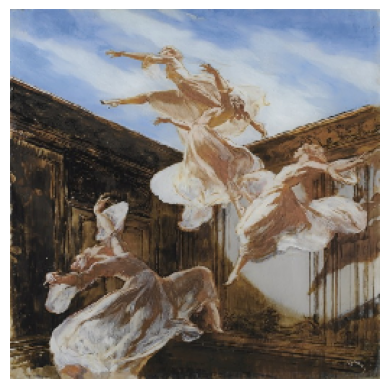

In [13]:
plt.imshow(X[0].astype('uint8'))
plt.axis('off')
plt.show()

In [14]:
X = (X - 127.5)/127.5

In [15]:
X.shape

(1, 256, 256, 3)

1/1 [==============================] - 6s 6s/step
d_lr: 0.7014946937561035, dlf: 0.7053936719894409, gl: 0.7110966444015503
1/1 [==============================] - 0s 172ms/step


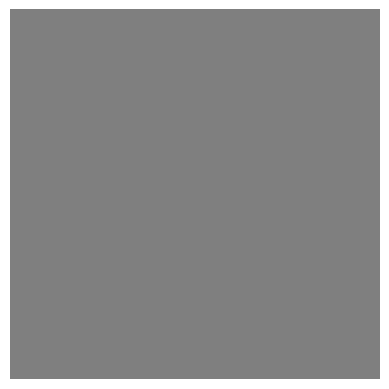

1/1 [==============================] - 0s 31ms/step
d_lr: 0.029775429517030716, dlf: 0.6612505912780762, gl: 0.797861635684967
1/1 [==============================] - 0s 19ms/step
d_lr: 0.00014407027629204094, dlf: 0.5529468059539795, gl: 1.133320689201355
1/1 [==============================] - 0s 19ms/step
d_lr: 2.8343783924356103e-06, dlf: 0.2706977128982544, gl: 2.67527437210083
1/1 [==============================] - 0s 18ms/step
d_lr: 4.059302227688022e-07, dlf: 0.022914526984095573, gl: 5.5773162841796875
1/1 [==============================] - 0s 19ms/step
d_lr: 1.4267573078541318e-07, dlf: 0.011364779435098171, gl: 7.137086868286133
1/1 [==============================] - 0s 18ms/step
d_lr: 2.5734368591656676e-07, dlf: 0.10251575708389282, gl: 56.49330520629883
1/1 [==============================] - 0s 19ms/step
d_lr: 0.0166291743516922, dlf: 2.012538544704512e-07, gl: 18.481529235839844
1/1 [==============================] - 0s 18ms/step
d_lr: 2.2700639111528087e-12, dlf: 8.470092

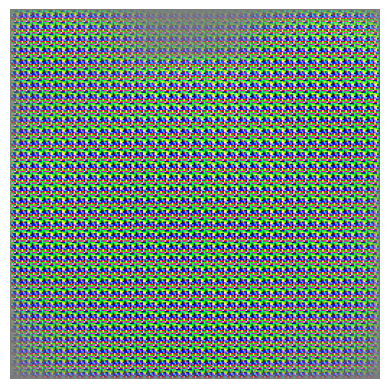

1/1 [==============================] - 0s 18ms/step
d_lr: 9.76643210748307e-10, dlf: 0.00032266409834846854, gl: 11.244037628173828
1/1 [==============================] - 0s 18ms/step
d_lr: 1.648136765952657e-10, dlf: 0.0010913776932284236, gl: 11.10936164855957
1/1 [==============================] - 0s 18ms/step
d_lr: 5.44048472939096e-10, dlf: 0.002446188824251294, gl: 9.564537048339844
1/1 [==============================] - 0s 18ms/step
d_lr: 8.250368721540724e-10, dlf: 0.0022954861633479595, gl: 10.998577117919922
1/1 [==============================] - 0s 18ms/step
d_lr: 2.7651933520722594e-10, dlf: 0.0017254279227927327, gl: 11.119771003723145
1/1 [==============================] - 0s 18ms/step
d_lr: 1.451477871228235e-08, dlf: 0.0010375945130363107, gl: 13.772421836853027
1/1 [==============================] - 0s 19ms/step
d_lr: 3.7108796938079e-12, dlf: 0.000628118752501905, gl: 11.460186004638672
1/1 [==============================] - 0s 18ms/step
d_lr: 1.6059243778537846e-12, 

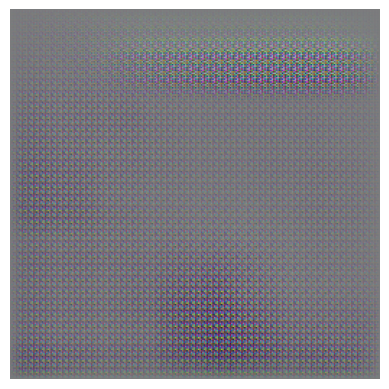

1/1 [==============================] - 0s 19ms/step
d_lr: 0.0005866475403308868, dlf: 0.029967717826366425, gl: 5.702301025390625
1/1 [==============================] - 0s 19ms/step
d_lr: 0.006880526430904865, dlf: 0.013190923258662224, gl: 5.9449992179870605
1/1 [==============================] - 0s 18ms/step
d_lr: 0.021096888929605484, dlf: 0.022436706349253654, gl: 4.44838809967041
1/1 [==============================] - 0s 18ms/step
d_lr: 1.2779345297531108e-06, dlf: 0.007197940722107887, gl: 5.038918495178223
1/1 [==============================] - 0s 20ms/step
d_lr: 2.827225387136423e-07, dlf: 0.0169293861836195, gl: 4.665670394897461
1/1 [==============================] - 0s 18ms/step
d_lr: 2.4898139372453443e-07, dlf: 0.017171211540699005, gl: 5.242613792419434
1/1 [==============================] - 0s 18ms/step
d_lr: 5.114771738590207e-06, dlf: 0.006326470524072647, gl: 6.3347625732421875
1/1 [==============================] - 0s 19ms/step
d_lr: 0.00020010674779769033, dlf: 0.00

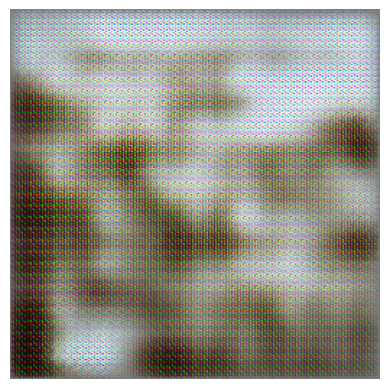

1/1 [==============================] - 0s 21ms/step
d_lr: 0.008024229668080807, dlf: 0.0579410120844841, gl: 3.905003786087036
1/1 [==============================] - 0s 18ms/step
d_lr: 0.0051708342507481575, dlf: 0.9745070338249207, gl: 21.0044002532959
1/1 [==============================] - 0s 18ms/step
d_lr: 2.7051267623901367, dlf: 1.693170332828231e-07, gl: 15.467636108398438
1/1 [==============================] - 0s 18ms/step
d_lr: 0.0025012174155563116, dlf: 0.0619729682803154, gl: 3.4384827613830566
1/1 [==============================] - 0s 20ms/step
d_lr: 0.00040403264574706554, dlf: 0.07454650104045868, gl: 3.7097175121307373
1/1 [==============================] - 0s 19ms/step
d_lr: 8.18559929030016e-05, dlf: 0.03458566591143608, gl: 2.59066104888916
1/1 [==============================] - 0s 19ms/step
d_lr: 0.000863071356434375, dlf: 0.3489333987236023, gl: 3.5113461017608643
1/1 [==============================] - 0s 19ms/step
d_lr: 0.002653741743415594, dlf: 0.086676724255084

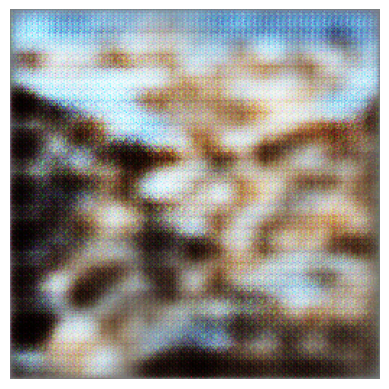

1/1 [==============================] - 0s 18ms/step
d_lr: 0.09284873306751251, dlf: 0.024591617286205292, gl: 4.245316505432129
1/1 [==============================] - 0s 18ms/step
d_lr: 0.045532651245594025, dlf: 0.008641167543828487, gl: 5.104212284088135
1/1 [==============================] - 0s 18ms/step
d_lr: 0.029287993907928467, dlf: 0.8816373348236084, gl: 6.7333197593688965
1/1 [==============================] - 0s 18ms/step
d_lr: 2.1096837520599365, dlf: 0.4210517704486847, gl: 2.063324213027954
1/1 [==============================] - 0s 18ms/step
d_lr: 0.01379404030740261, dlf: 0.9686877131462097, gl: 4.713665008544922
1/1 [==============================] - 0s 18ms/step
d_lr: 0.31745558977127075, dlf: 0.017354164272546768, gl: 5.19167423248291
1/1 [==============================] - 0s 18ms/step
d_lr: 0.42414116859436035, dlf: 0.10435117781162262, gl: 2.652055025100708
1/1 [==============================] - 0s 18ms/step
d_lr: 0.027408542111516, dlf: 0.31247666478157043, gl: 2.7

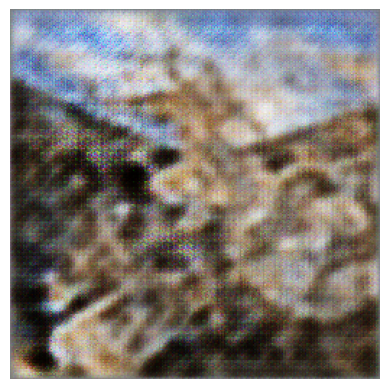

1/1 [==============================] - 0s 18ms/step
d_lr: 0.026211243122816086, dlf: 0.11246319860219955, gl: 3.3138065338134766
1/1 [==============================] - 0s 19ms/step
d_lr: 0.06733643263578415, dlf: 0.07523773610591888, gl: 3.73547101020813
1/1 [==============================] - 0s 19ms/step
d_lr: 0.07550375163555145, dlf: 0.09429100900888443, gl: 3.265294075012207
1/1 [==============================] - 0s 18ms/step
d_lr: 0.10870631784200668, dlf: 0.13660287857055664, gl: 3.240542411804199
1/1 [==============================] - 0s 18ms/step
d_lr: 0.07642261683940887, dlf: 0.07254210114479065, gl: 3.670349597930908
1/1 [==============================] - 0s 19ms/step
d_lr: 0.09753270447254181, dlf: 0.11253152787685394, gl: 3.1504385471343994
1/1 [==============================] - 0s 18ms/step
d_lr: 0.0370405837893486, dlf: 0.09039468318223953, gl: 3.7266440391540527
1/1 [==============================] - 0s 19ms/step
d_lr: 0.10544511675834656, dlf: 0.10097695887088776, gl: 

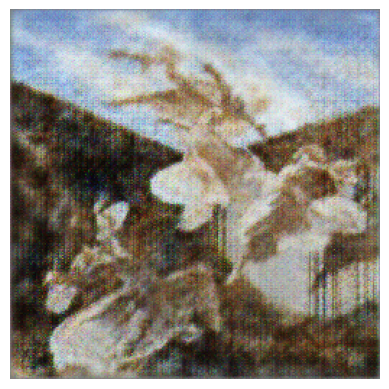

1/1 [==============================] - 0s 20ms/step
d_lr: 0.10526110976934433, dlf: 0.030650952830910683, gl: 3.681047201156616
1/1 [==============================] - 0s 19ms/step
d_lr: 0.06610947847366333, dlf: 0.20562639832496643, gl: 4.9424638748168945
1/1 [==============================] - 0s 19ms/step
d_lr: 0.333423912525177, dlf: 0.6654821038246155, gl: 5.312725067138672
1/1 [==============================] - 0s 20ms/step
d_lr: 0.6241305470466614, dlf: 1.068661093711853, gl: 4.987774848937988
1/1 [==============================] - 0s 18ms/step
d_lr: 0.35922786593437195, dlf: 0.04677145928144455, gl: 3.2809739112854004
1/1 [==============================] - 0s 18ms/step
d_lr: 0.14652100205421448, dlf: 0.14021992683410645, gl: 2.6819443702697754
1/1 [==============================] - 0s 18ms/step
d_lr: 0.04683713614940643, dlf: 0.1373167634010315, gl: 3.6291496753692627
1/1 [==============================] - 0s 19ms/step
d_lr: 0.10984314978122711, dlf: 0.06769093126058578, gl: 3.48

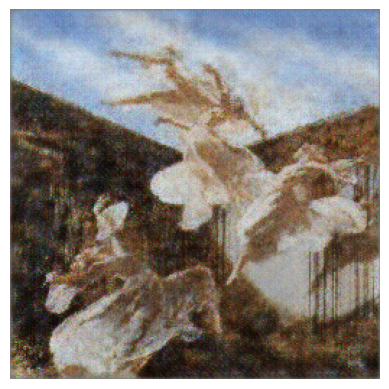

1/1 [==============================] - 0s 20ms/step
d_lr: 0.08413088321685791, dlf: 0.08271968364715576, gl: 3.4685006141662598
1/1 [==============================] - 0s 18ms/step
d_lr: 0.18403975665569305, dlf: 0.14861756563186646, gl: 2.4068198204040527
1/1 [==============================] - 0s 19ms/step
d_lr: 0.09209586679935455, dlf: 0.2239397019147873, gl: 3.806708812713623
1/1 [==============================] - 0s 19ms/step
d_lr: 0.28980374336242676, dlf: 0.27844610810279846, gl: 3.5710978507995605
1/1 [==============================] - 0s 20ms/step
d_lr: 0.1427685171365738, dlf: 0.11565534770488739, gl: 3.4614405632019043
1/1 [==============================] - 0s 20ms/step
d_lr: 0.16641631722450256, dlf: 0.2159726619720459, gl: 3.7169437408447266
1/1 [==============================] - 0s 19ms/step
d_lr: 0.204912930727005, dlf: 0.15588289499282837, gl: 3.198896646499634
1/1 [==============================] - 0s 41ms/step
d_lr: 0.08468060195446014, dlf: 0.08957692980766296, gl: 3.

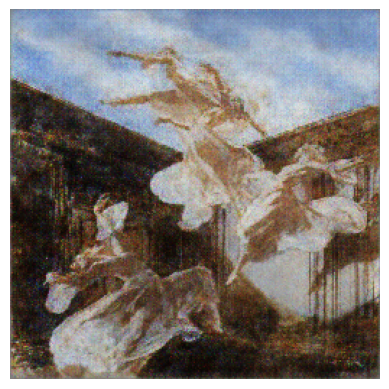

1/1 [==============================] - 0s 20ms/step
d_lr: 0.7429605722427368, dlf: 1.4278162717819214, gl: 3.30295467376709
1/1 [==============================] - 0s 18ms/step
d_lr: 0.516021728515625, dlf: 0.23265454173088074, gl: 2.54864501953125
1/1 [==============================] - 0s 19ms/step
d_lr: 0.23726075887680054, dlf: 0.2878839671611786, gl: 2.5149106979370117
1/1 [==============================] - 0s 18ms/step
d_lr: 0.19608044624328613, dlf: 0.20117288827896118, gl: 2.6985676288604736
1/1 [==============================] - 0s 18ms/step
d_lr: 0.1619667261838913, dlf: 0.1377810686826706, gl: 2.6923789978027344
1/1 [==============================] - 0s 18ms/step
d_lr: 0.10657158493995667, dlf: 0.20565369725227356, gl: 3.158874750137329
1/1 [==============================] - 0s 33ms/step
d_lr: 0.20656505227088928, dlf: 0.1323973834514618, gl: 2.406674861907959
1/1 [==============================] - 0s 18ms/step
d_lr: 0.10530048608779907, dlf: 0.25082963705062866, gl: 2.9724121

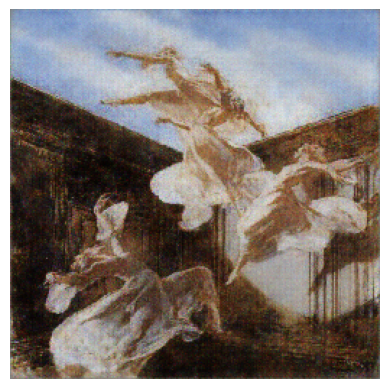

1/1 [==============================] - 0s 21ms/step
d_lr: 0.15892426669597626, dlf: 0.11761049926280975, gl: 3.276482582092285
1/1 [==============================] - 0s 21ms/step
d_lr: 0.08833366632461548, dlf: 0.17493681609630585, gl: 3.145522117614746
1/1 [==============================] - 0s 21ms/step
d_lr: 0.16462069749832153, dlf: 0.20533278584480286, gl: 3.652033567428589
1/1 [==============================] - 0s 21ms/step
d_lr: 0.1738843023777008, dlf: 0.17376530170440674, gl: 3.7422637939453125
1/1 [==============================] - 0s 21ms/step
d_lr: 0.30125290155410767, dlf: 0.5130510330200195, gl: 3.8444080352783203
1/1 [==============================] - 0s 21ms/step
d_lr: 1.2035315036773682, dlf: 0.8780456781387329, gl: 5.975973606109619
1/1 [==============================] - 0s 21ms/step
d_lr: 1.5924113988876343, dlf: 0.5276024341583252, gl: 5.199728965759277
1/1 [==============================] - 0s 21ms/step
d_lr: 0.9298967123031616, dlf: 1.039034366607666, gl: 1.7085154

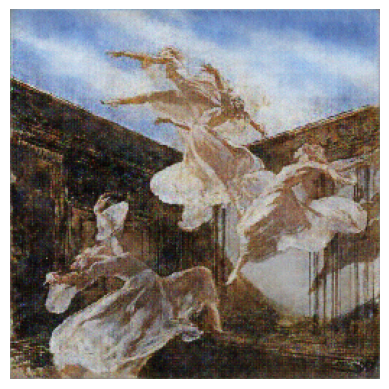

d_lr: 0.6059374809265137, dlf: 0.8361954092979431, gl: 1.5349323749542236


In [16]:
train(generator, discriminator, gan, X, latent_dim, epochs= 1000, batch_size= 16)

1/1 [==============================] - 0s 19ms/step


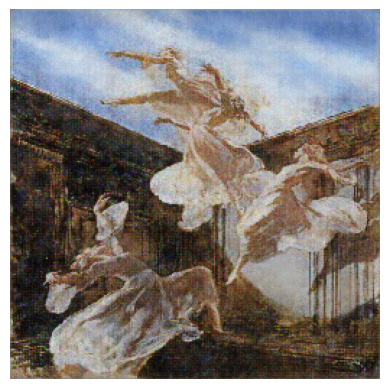

In [17]:
gen_portrait()